<h1><center><b> Named Entity Recognition </b></center></h1>

#### NER is used for extraction such entities from the text as persons, organizations, locations, etc. Here we try to recognize named entities from Twitter with LSTMs

#### Here we will use a recurrent neural network model which will be made using KERAS Functional API and to solve our NER problem. In addition we will use Pre-Trained GLoVe Embedding, Many to Many Architecture for last layer(TimeDistributed) and for monitoring and evaluation we will use Callbacks such EarlyStopping and TensorBoard

In [1]:
# Hide tensorflow warnings
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.WARNING)

In [17]:
# Important Libraries needed

import datetime
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, optimizers
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Bidirectional,
    Dense,
    Dropout,
    Embedding,
    TimeDistributed,
)
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
print(tf.__version__)
print(np.__version__)

2.6.0
1.21.2


#### Note: Sometimes we have to run the above cell for importing libraries again as tensorflow or keras module is unable to get imported the first time due to some bug. If later on, if we get an error when compiling our mode or our settings optimizers etc, re-run the import library cell again.
#### Note: Tensorflow 2.5 and numpy 1.20 and 1.21 will result in an error when building the model as Tensforflow uses numpy ver 1.19.5 internally for calculations.  

In [4]:
# Note: 'with' automatically closes file 

with open('data/train.txt') as f:
    line = [f.readline() for i in range(100)]
    print(line)

['RT O\n', '@TheValarium O\n', ': O\n', 'Online O\n', 'ticket O\n', 'sales O\n', 'for O\n', 'Ghostland B-musicartist\n', 'Observatory I-musicartist\n', 'extended O\n', 'until O\n', '6 O\n', 'PM O\n', 'EST O\n', 'due O\n', 'to O\n', 'high O\n', 'demand O\n', '. O\n', 'Get O\n', 'them O\n', 'before O\n', 'they O\n', 'sell O\n', 'out O\n', '... O\n', '\n', 'Apple B-product\n', 'MacBook I-product\n', 'Pro I-product\n', 'A1278 I-product\n', '13.3 I-product\n', '" I-product\n', 'Laptop I-product\n', '- I-product\n', 'MD101LL/A I-product\n', '( O\n', 'June O\n', ', O\n', '2012 O\n', ') O\n', '- O\n', 'Full O\n', 'read O\n', 'by O\n', 'eBay B-company\n', 'http://t.co/2zgQ99nmuf O\n', 'http://t.co/eQmogqqABK O\n', '\n', 'Happy O\n', 'Birthday O\n', '@AshForeverAshey O\n', '! O\n', 'May O\n', 'Allah B-person\n', 's.w.t O\n', 'bless O\n', 'you O\n', 'with O\n', 'goodness O\n', 'and O\n', 'happiness O\n', '. O\n', '\n', '@AqwSkills O\n', 'the O\n', 'quest O\n', 'line O\n', 'im O\n', 'assuming O\n'

#### Reading twitter text file format, we note every line contains a pair of a token (word/punctuation symbol) and a tag, separated by a whitespace and different tweets are separated by an empty line. 

#### Further, we see different user names start after an '@' symbol and also there are different url's. These can be replaced by an identification token as they won't be useful by themselves in our model.

In [5]:
""" Function to read twitter text file and return a separated list of tokens and its corresponding tags """

def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            # Replace all urls with <URL> token
            # Replace all users with <USR> token

            if token.startswith("@"):
                token="<USR>"
            elif token.startswith("http://") or token.startswith("https://"):
                token="<URL>"
            
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    return tokens, tags

In [6]:
train_tokens, train_tags = read_data('data/train.txt')
val_tokens, val_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

#### Saving our tokens and tags into train,validation and test sets.
 - *train* data for training the model;
 - *validation* data for evaluation and hyperparameters tuning;
 - *test* data for final evaluation of the model.

In [7]:
for i in range(2):
    print("----- Sentence {0} :- -----".format(i+1))
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print ("----------------------- \n")

----- Sentence 1 :- -----
RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O
----------------------- 

----- Sentence 2 :- -----
Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O
----------------------- 



#### Checking our training set list for tokens and tags

-----------------------------------

# Data Pre-Processing

#### To train our neural network, we will create a dictionary with two mappings:
- token → token id: use integers as input data of KERAS embedding layer so that words can be represented     by dense vectors (More memory and computationally efficient than One-Hot Encoding)
- tag → tag id: use integers for computing the loss at the output of the network.

#### Note: Here we are considering that we have single-class labels, where an object can only belong to one class, i.e. each token belongs to a particular tag or vice-versa. Hence, we can use "sparse_categorical_crossentropy" instead of "categorical_crossentropy" as our loss function which requires one-hot-encoded vectors

#### Note: We will also need to add some 'Special tokens and tags' to our dictionary. They will be unknown tokens and padding tokens/tags.
- &lt;UNK&gt; token to represent of vocabulary tokens;
- &lt;PAD&gt; tokens and tags for padding sentence to the same length when we create batches of sentences

In [8]:
""" Dictionary to create mappings for tokens and tags """

def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    
# Note: First add special tokens and tags to the dictionaries and the first special token must have index 0
# Here, first special token must be for "pad" as later on we can use an in-built KERAS function for masking
# pads to avoid extra copmutations i.e. mask_zero which only applies for value 0 (index 0 here)
    
    k = 0
    for line in special_tokens:
        tok2idx[line] = k
        k += 1
        idx2tok.append(line)
        
    for tokens in tokens_or_tags:
        for token in tokens:
            if token not in tok2idx: 
                tok2idx[token] = k 
                k += 1
                idx2tok.append(token)
    
    return tok2idx, idx2tok

In [9]:
special_tokens = ['<PAD>', '<UNK>']
special_tags = ['<PAD>']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + val_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags + val_tags , special_tags)

####  Implemented the function build_dict and creating dictionaries for our tokens and tags.
#### Note: We always consider test tokens and tags to be unseen/unknown and hence don't use them when creating our dicitonaries.

## Padding Input Sentences

#### The LSTM layers only accepts sequences within a batch that are of same lengths. It means that weight updates of the network are based on several sequences at every single time. So we will pad shorter sequences within a batch with a special token (&lt;PAD&gt;) to match the length of the largest sequence in that batch, thus making all sequences of equal length for every batch. This technique is also known as bucketing

#### We will define a function to generate batches of equal length which can then be fed into our neural network model. For this, we will define 3 functions :-
* helper function to generate the number of batches for a given batch size
* helper function to create list of the mapped id's from tokens when given a sentence
* function for generating batches with sequences of equal lengths by applying padding using the 2 helper functions  

In [10]:
def n_batches(batch_size, tokens, allow_smaller_last_batch = True):
    n_samples = len(tokens)
    n_batches = n_samples // batch_size                          ### '//' for floor division 
    if allow_smaller_last_batch and n_samples % batch_size:
        n_batches += 1
    return n_batches

In [11]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] for tag in tags_list]

In [12]:
def batches_generator(batch_size, n_batches, tokens, tags,
                      shuffle = True):
    """Generates padded batches of tokens and tags."""
    while True:                       ### 'while' loop used for looping through epochs in train.fit() 
        n_samples = len(tokens)
        if shuffle:
            order = np.random.permutation(n_samples)
        else:
            order = np.arange(n_samples)
    
        for k in range(n_batches):
            batch_start = k * batch_size
            batch_end = min((k + 1) * batch_size, n_samples)
            current_batch_size = batch_end - batch_start
            x_list = []
            y_list = []
            max_len_token = 0
            for idx in order[batch_start: batch_end]:
                x_list.append(words2idxs(tokens[idx]))
                y_list.append(tags2idxs(tags[idx]))
                max_len_token = max(max_len_token, len(tags[idx]))
                
            # Fill in the data into numpy nd-arrays filled with padding indices.
            x = np.ones([current_batch_size, max_len_token], dtype=np.int32) * token2idx['<PAD>']
            y = np.ones([current_batch_size, max_len_token], dtype=np.int32) * tag2idx['<PAD>']        
            for n in range(current_batch_size):
                utt_len = len(x_list[n])
                x[n, :utt_len] = x_list[n]
                y[n, :utt_len] = y_list[n]
            yield x, y

#### Note: We will provide RNN and loss function with sequence lengths, so it can skip computations for padding parts. For this we can use KERAS mask_zero param to remove the paddings parts for computation.
#### Helper function 'n_batches' has to be separate from 'batches_generator' function as later on we will be using 'fit' method for training our model which requires number of batches as input for steps_per_epoch param when using a generator as input for X(input data) param. However, when using 'train_on_batch' method instead of 'fit' method we can include them in a single function as well. For a similar reason we have used a 'while' loop in 'batches_generator' function to loop through epochs which will be declared in our 'fit' method.

# Implementing Model Architecture

#### We will create an LSTM network which will produce probability distribution over tags for each token in a sentence. To take into account both right and left contexts of the token, we will use Bi-Directional LSTM (Bi-LSTM). Dense layer will be used on top to perform tag classification. We will use Keras Functional API to build our model.

#### We will set our input shape as 'None' so that we can accept sequences of variable length

#### 'mask_zero' param will be set to True in 'Embedding' layer so as to to avoid computations for padding tokens inside the RNN and also when computing loss function.

#### We will set 'dropout' param in our RNN layer for regularization.

#### Here we use 'Time Distributed Layer'(Many to Many architecture) instead of the single 'Dense Layer'(Many to One architecture) as output layer. The TimeDistributed applyies the same Dense layer (same weights) to the LSTMs outputs for one time step at a time. In this way, the output layer only needs one connection to each LSTM unit (plus one bias). For this reason, the number of training epochs needs to be increased to account for the smaller network capacity

#### We will use 'softmax' in our activation function for output lyer, as it will provide us a multinominal probability distribution for our multi-label classification problem

#### Our Loss Function will be "sparse_categorical_crossentropy" (No need for OHC, can use integers)

#### The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

- input_dim: This is the size of the vocabulary in the text data. Here, it will length of token dictionary   consisting of 
- output_dim: This is the size of the vector space in which words will be embedded. It defines the size of   the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger.       Here, we will use 200.
- input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. Here, it will max sentence length from our training and validations dataset.

#### Here we will use pre-trained GloVe (Global Vectors for Word Representation) Embedding

## GloVE Embedding

#### Use the following command to download pre-trained GloVe embeddings (a 822M zip file):-
* !wget http://nlp.stanford.edu/data/glove.6B.zip
* !unzip -q glove.6B.zip

#### The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones, i.e. "glove.6B.100d.txt“.  In the file we can see that the token (word) is followed by the weights (100 numbers) on each line.
#### To use pre-trained GloVe embeddings we will have to perform the following steps:-
* load the whole embedding into memory
* prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index 'i' is the pre-trained vector for the word of index i in our vectorizer's vocabulary.
* load the pre-trained word embeddings matrix into an Embedding layer.

#### Note: Instead of loading the whole embedding into memory (speed up our process and save disk space), we can also filter the embeddings for the unique words in our training and validation data. To access the mapping of word to vector dictionary for our unique words we can use model.wv.vocab

In [13]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Embedding layer must be defined with output_dim set to 100, as we chose the 100-dimensional text-encoded vectors. Also, Embedding layer is seeded with the GloVe word embedding weights. 

In [14]:
input_dim = len(idx2token)
output_dim = 100

In [15]:
# Prepare embedding matrix
embedding_matrix = np.zeros((input_dim, output_dim))
for word, i in token2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector

In [18]:
embed_layer = Embedding(input_dim = input_dim, output_dim = output_dim, 
                   trainable = False, mask_zero = True, 
                   embeddings_initializer = keras.initializers.Constant(embedding_matrix))

#### Note: that we set trainable = False so as to keep the embeddings fixed (we don't want to update them (learned word weights) during training)

#### The output dense layer length should be equal to number of labels i.e. tags

In [19]:
num_tags = len(idx2tag)

#### Initialized input and output parameters for our model

## Setting Optimizer for our model

#### We will use adam optimization algorithm with learning rate decay. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. An initially large learning rate suppresses the network from memorizing noisy data while decaying the learning rate improves the learning of complex patterns.
#### Note: We can also use 'Adaptive Moment Estimation' instead of learning rate schedules method as it can be challenging to configure and is critical to the performance of a deep learning neural network model. 

#### We also apply clipping to eliminate exploding gradients. Here, we use 'global_clipnorm' function in KERAS which clips only gradients and not variables. Also, function 'clip_norm' clips the gradient of each weight independently of the gradients of the other weights and thus has the disadvantage of changing the descent direction, whereas with global_clipnorm the direction would remain unchanged.

In [20]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-2,
    decay_steps = 10000,
    decay_rate = 0.9)

opt = keras.optimizers.Adam(learning_rate = lr_schedule, global_clipnorm = 1.0)

## Callbacks

#### We will use EarlyStopping and Tensorboard callbacks. 

#### EarlyStopping is used so that we don’t need to hard code the number of epochs. If our network doesn’t improve for 2 consecutive epochs,i.e. validation loss is not decreased we are going to stop our training process. The 'patience' param will define that and as we are monitoring loss, our 'mode' param will be min and also we will set 'restore_best_weights' param as True.

#### We will also use Tensorboard to monitor and evaluate our data which has a lot of different options and settings.

In [21]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
!rm -rf ./logs/

In [33]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1,                                                 write_graph = True, write_images = True, 
                                                update_freq = 'epoch', profile_batch = 2,
                                                embeddings_freq = 1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', min_delta = 0, patience = 2, 
                                                  verbose = 0, mode = 'min', baseline = None, 
                                                  restore_best_weights = True)

callbacks = [tensorboard_cb, early_stopping]

## KERAS BI-LSTM Model

In [34]:
input_seq = Input(shape = (None,))
model = (embed_layer)(input_seq)

forward_layer = keras.layers.RNN(
            keras.layers.LSTMCell(100, dropout = 0.5), return_sequences = True)
backward_layer = keras.layers.RNN(
            keras.layers.LSTMCell(100, dropout = 0.5), return_sequences = True, go_backwards = True)

model = (Bidirectional(forward_layer, backward_layer = backward_layer))(model)
out = (TimeDistributed(Dense(num_tags, activation = "softmax")))(model)

model = Model(input_seq, out)

model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["Accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2050500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 22)          4422      
Total params: 2,215,722
Trainable params: 165,222
Non-trainable params: 2,050,500
_________________________________________________________________


#### After compiling, we will train our data and conduct more experiments as needed to tune our hyperparameters, to obtain higher accuracy on the held-out validation dataset.
#### The hyperparameters for our model are :- batch_size, epochs, learning_rate params, global_clip_norm, dropout.
#### For training our model we will be using 'fit' method but in 'x' param (input data) and 'validation_data' param we will use a generator as sequences are of different lengths. Also, as we will be using a generator we will have assign values for 'steps_per_epoch' and 'validation_steps' pararms instead of batch_size.
#### To use a generator for training our model we will define a function which will make use of 'n_batches' and 'batches_generator' functions defined earlier.

In [37]:
""" To train a model using a Generator """

def train_model(x_train , y_train, x_val = None, y_val = None, batch_size = 32, epochs = 2, verbose = 1):    
    n_batch_train = n_batches(batch_size, x_train)    
    if x_val:
        n_batch_val = n_batches(batch_size, x_val)

    history = model.fit(
        x = batches_generator(batch_size, n_batch_train, x_train, y_train, epochs),
        y = None,
        steps_per_epoch = n_batch_train,
        validation_data = batches_generator(batch_size, n_batch_val, x_val, y_val, epochs),
        validation_steps = n_batch_val,
        epochs = epochs,
        verbose = verbose,
        callbacks = callbacks
    )
    return history

In [38]:
history = train_model(train_tokens, train_tags, val_tokens, val_tags, batch_size = 32, epochs = 10)

Epoch 1/10
182/182 [==============================] - 43s 235ms/step - loss: 0.1978 - Accuracy: 0.9242 - val_loss: 0.1827 - val_Accuracy: 0.9250
Epoch 2/10
182/182 [==============================] - 39s 216ms/step - loss: 0.1924 - Accuracy: 0.9241 - val_loss: 0.1786 - val_Accuracy: 0.9252
Epoch 3/10
182/182 [==============================] - 38s 209ms/step - loss: 0.1818 - Accuracy: 0.9262 - val_loss: 0.1725 - val_Accuracy: 0.9280
Epoch 4/10
182/182 [==============================] - 37s 201ms/step - loss: 0.1784 - Accuracy: 0.9268 - val_loss: 0.1664 - val_Accuracy: 0.9291
Epoch 5/10
182/182 [==============================] - 39s 213ms/step - loss: 0.1732 - Accuracy: 0.9275 - val_loss: 0.1735 - val_Accuracy: 0.9244
Epoch 6/10
182/182 [==============================] - 38s 208ms/step - loss: 0.1726 - Accuracy: 0.9277 - val_loss: 0.1617 - val_Accuracy: 0.9286
Epoch 7/10
182/182 [==============================] - 40s 217ms/step - loss: 0.1691 - Accuracy: 0.9280 - val_loss: 0.1577 - val_Ac

#### Note: When evaluating results for each epoch, be careful to not use custom metrics (F1/F2 score) directly through keras metric function that is calculated during training(fit) as it is done on batches (not together) and might show misleading results. Keras inbuilt metrics (tensorflow 2) use specialised built-in accumulators, and the computations are made properly. However, note it is possible to use custom metrics by other methods like backend utilities, callbacks, base layer API's.

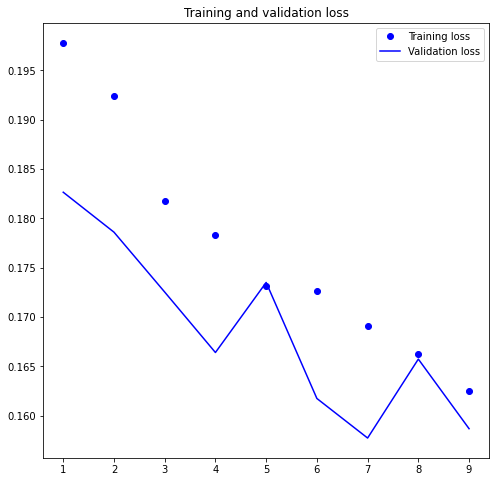

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### We observe our training loss is still decreasing at 10 epochs and validation loss is fluctating and might decrease further. We can increase the number of epochs to check the future trend of our losses and our model might still be underfitting.

In [39]:
%tensorboard --logdir logs/fit

#### From Tensorboard, we can monitor and evaluate various options, like scalars, graphs, distributions, histogram, embeddings,profiler etc

## Evaluation on Test Dataset

#### We will be using CoNLL-2003 shared task as our evaluation metric. It measures the performance of the systems in terms of precision, recall and f1-score, where: 
- precision is the percentage of named entities found by the learning system that are correct. 
- Recall is the percentage of named entities present in the corpus that are found by the system. 
- A named entity is correct only if it is an exact match of the corresponding entity in the data file.
#### We consider 3 scenarios here, namely :-
- Surface string and entity type match
- System hypothesized an entity
- System misses an entity

#### Note: We can use other evaluation metric for NER like Automatic Content Extraction (ACE) or Message Understanding Conference (MUC) which considers other scenarios for partial matches as well.

#### Define a function which will calculate our evaluation metrics as per CoNLL-2003 evaluation scheme

In [41]:
from collections import OrderedDict

def _update_chunk(candidate, prev, current_tag, current_chunk, current_pos, prediction=False):
    if candidate == 'B-' + current_tag:
        if len(current_chunk) > 0 and len(current_chunk[-1]) == 1:
                current_chunk[-1].append(current_pos - 1)
        current_chunk.append([current_pos])
    elif candidate == 'I-' + current_tag:
        if prediction and (current_pos == 0 or current_pos > 0 and prev.split('-', 1)[-1] != current_tag):
            current_chunk.append([current_pos])
        if not prediction and (current_pos == 0 or current_pos > 0 and prev == 'O'):
            current_chunk.append([current_pos])
    elif current_pos > 0 and prev.split('-', 1)[-1] == current_tag:
        if len(current_chunk) > 0:
            current_chunk[-1].append(current_pos - 1)

def _update_last_chunk(current_chunk, current_pos):
    if len(current_chunk) > 0 and len(current_chunk[-1]) == 1:
        current_chunk[-1].append(current_pos - 1)

def _tag_precision_recall_f1(tp, fp, fn):
    precision, recall, f1 = 0, 0, 0
    if tp + fp > 0:
        precision = tp / (tp + fp) * 100
    if tp + fn > 0:
        recall = tp / (tp + fn) * 100
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def _aggregate_metrics(results, total_correct):
    total_true_entities = 0
    total_predicted_entities = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    for tag, tag_metrics in results.items():
        n_pred = tag_metrics['n_predicted_entities']
        n_true = tag_metrics['n_true_entities']
        total_true_entities += n_true
        total_predicted_entities += n_pred
        total_precision += tag_metrics['precision'] * n_pred
        total_recall += tag_metrics['recall'] * n_true
    
    accuracy = 0
    if total_true_entities > 0:
        accuracy = total_correct / total_true_entities * 100
    else:
        print('CAUTION! Accuracy equals zero because there are no '\
              'correct entities. Check the correctness of your data.')
    if total_predicted_entities > 0:
        total_precision = total_precision / total_predicted_entities
    total_recall = total_recall / total_true_entities
    if total_precision + total_recall > 0:
        total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall)
    return total_true_entities, total_predicted_entities, \
           total_precision, total_recall, total_f1, accuracy

def _print_info(n_tokens, total_true_entities, total_predicted_entities, total_correct):
    print('processed {len} tokens ' \
          'with {tot_true} phrases; ' \
          'found: {tot_pred} phrases; ' \
          'correct: {tot_cor}.\n'.format(len=n_tokens,
                                         tot_true=total_true_entities,
                                         tot_pred=total_predicted_entities,
                                         tot_cor=total_correct))

def _print_metrics(accuracy, total_precision, total_recall, total_f1):
    print('precision:  {tot_prec:.2f}%; ' \
          'recall:  {tot_recall:.2f}%; ' \
          'F1:  {tot_f1:.2f}%\n'.format(acc=accuracy,
                                           tot_prec=total_precision,
                                           tot_recall=total_recall,
                                           tot_f1=total_f1))

def _print_tag_metrics(tag, tag_results):
    print(('\t%12s' % tag) + ': precision:  {tot_prec:6.2f}%; ' \
                               'recall:  {tot_recall:6.2f}%; ' \
                               'F1:  {tot_f1:6.2f}; ' \
                               'predicted:  {tot_predicted:4d}\n'.format(tot_prec=tag_results['precision'],
                                                                         tot_recall=tag_results['recall'],
                                                                         tot_f1=tag_results['f1'],
                                                                         tot_predicted=tag_results['n_predicted_entities']))

def precision_recall_f1(y_true, y_pred, print_results=True, short_report=False):
    # Find all tags
    tags = sorted(set(tag[2:] for tag in y_true + y_pred if tag != 'O'))

    results = OrderedDict((tag, OrderedDict()) for tag in tags)
    n_tokens = len(y_true)
    total_correct = 0

    # For eval_conll_try we find all chunks in the ground truth and prediction
    # For each chunk we store starting and ending indices
    for tag in tags:
        true_chunk = list()
        predicted_chunk = list()
        for position in range(n_tokens):
            _update_chunk(y_true[position], y_true[position - 1], tag, true_chunk, position)
            _update_chunk(y_pred[position], y_pred[position - 1], tag, predicted_chunk, position, True)

        _update_last_chunk(true_chunk, position)
        _update_last_chunk(predicted_chunk, position)

        # Then we find all correctly classified intervals
        # True positive results
        tp = sum(chunk in predicted_chunk for chunk in true_chunk)
        total_correct += tp

        # And then just calculate errors of the first and second kind
        # False negative
        fn = len(true_chunk) - tp
        # False positive
        fp = len(predicted_chunk) - tp
        precision, recall, f1 = _tag_precision_recall_f1(tp, fp, fn)

        results[tag]['precision'] = precision
        results[tag]['recall'] = recall
        results[tag]['f1'] = f1
        results[tag]['n_predicted_entities'] = len(predicted_chunk)
        results[tag]['n_true_entities'] = len(true_chunk)

    total_true_entities, total_predicted_entities, \
           total_precision, total_recall, total_f1, accuracy = _aggregate_metrics(results, total_correct)

    if print_results:
        _print_info(n_tokens, total_true_entities, total_predicted_entities, total_correct)
        _print_metrics(accuracy, total_precision, total_recall, total_f1)

        if not short_report:
            for tag, tag_results in results.items():
                _print_tag_metrics(tag, tag_results)
    return results

In [42]:
def predict_tags(token_idxs_):
    """Performs predictions and transforms indices to tokens and tags."""
    
    token_idxs_batch = np.expand_dims(token_idxs_,0)
    tag_idxs_batch = model.predict(token_idxs_batch)
    tag_idxs_batch = np.argmax(tag_idxs_batch, axis = -1)

    tags_batch, tokens_batch = [], []
    for tag_idxs, token_idxs in zip(tag_idxs_batch, token_idxs_batch):
        tags, tokens = [], []
        for tag_idx, token_idx in zip(tag_idxs, token_idxs):            
            tags.append(idx2tag[tag_idx])
            tokens.append(idx2token[token_idx])
        tags_batch.append(tags)
        tokens_batch.append(tokens)        
    return tags_batch, tokens_batch
    
    
def eval_conll(tokens, tags, short_report = True):
    """Computes NER quality measures using CONLL shared task script."""
    y_true, y_pred = [], []

    for x_batch, y_batch in zip(tokens, tags):
        x_batch_id = words2idxs(x_batch)
        y_batch_id = tags2idxs(y_batch)
        tags_batch, tokens_batch = predict_tags(x_batch_id)
        y_true_batch = np.expand_dims(y_batch_id,0)      
        
        predicted_tags = []
        ground_truth_tags = []
        for gt_tag_idx, pred_tag, token in zip(y_true_batch[0], tags_batch[0], tokens_batch[0]): 
            if token != '<PAD>':
                ground_truth_tags.append(idx2tag[gt_tag_idx])
                predicted_tags.append(pred_tag)

        # We extend every prediction and ground truth sequence with 'O' tag
        # to indicate a possible end of entity.
        y_true.extend(ground_truth_tags + ['O'])
        y_pred.extend(predicted_tags + ['O'])
          
    results = precision_recall_f1(y_true, y_pred, print_results = True, short_report = short_report)
    return (results)

#### After defining  our evaluation metrics, we can finally evaualte our test dataset.

In [43]:
test_results = eval_conll(test_tokens, test_tags, short_report = False)

processed 11742 tokens with 425 phrases; found: 123 phrases; correct: 56.

precision:  45.53%; recall:  13.18%; F1:  20.44%

	     company: precision:   80.00%; recall:    7.02%; F1:   12.90; predicted:     5

	    facility: precision:   37.21%; recall:   39.02%; F1:   38.10; predicted:    43

	     geo-loc: precision:   64.71%; recall:   27.27%; F1:   38.37; predicted:    51

	       movie: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	 musicartist: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	       other: precision:    6.67%; recall:    1.32%; F1:    2.20; predicted:    15

	      person: precision:   22.22%; recall:    2.86%; F1:    5.06; predicted:     9

	     product: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	  sportsteam: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	      tvshow: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0



#### We observe a F1 score of about 21%. We can conduct more experiments to tune our hyperparameters and compare our results.

## Conclusion

#### For our small training corpora (in comparison with usual sizes of corpora in Deep Learning), our results are very poor in comparison to the previous methods. As mentioned earlier, our model might also be underfitting and we could increase the number of epochs to see if it improves our prediction. We could try pre-trained GloVe embedding in combination with Dense layer in output(previous models) or try using TimeDistributed layer without using Glove Embedding. We could also try using some other pre-trained embedding like 'Gensim's Wordtovec', ''Google's word2cec', 'Wikipedia2Vec', 'SpaCy' etc.